In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time as t
import cv2
import warnings
import shutil
import os

# Sklearn utils.
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

# TensorFlow and Keras.
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Flatten,
    Input,
    ZeroPadding2D,
    GlobalAveragePooling2D,
    Conv2D,
    MaxPooling2D,
    BatchNormalization,
)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set image data format to channels last
# Set image data format to channels last
tf.keras.backend.set_image_data_format("channels_last")



C:\Users\Lakshmi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import os

# Define your paths and parameters
PATH = "C:\\Users\\Lakshmi\\Untitled Folder 1\\"
PATH_CLASSES = ["mild", "severe", "no_dr", "proliferate_DR", "moderate"]

# Iterate over class folders and list their contents
for class_name in PATH_CLASSES:
    class_path = os.path.join(PATH, class_name)
    print(f"Contents of {class_name} folder:")
    print(os.listdir(class_path))
    print("=" * 50)


Contents of mild folder:
['0024cdab0c1e.png', '00cb6555d108.png', '0124dffecf29.png', '01b3aed3ed4c.png', '0369f3efe69b.png', '03e25101e8e8.png', '04ac765f91a1.png', '059bc89df7f4.png', '05a5183c92d0.png', '0684311afdfc.png', '06b71823f9cd.png', '07929d32b5b3.png', '07a1c7073982.png', '086d41d17da8.png', '09935d72892b.png', '0a3202889f4d.png', '0a61bddab956.png', '0ad7f631dedb.png', '0d310aba6373.png', '0dc031c94225.png', '0dce95217626.png', '0eb52045349f.png', '0f495d87656a.png', '0fb1053285cf.png', '101b9ebfc720.png', '107aea0d9289.png', '10f36b0239fb.png', '1116271db4ea.png', '111898ab463d.png', '12ce6a1a1f31.png', '12e3f5f2cb17.png', '13ab8db8c700.png', '15cc2aef772a.png', '172df1330a60.png', '17eff993386f.png', '18b06f56ab27.png', '194814669fee.png', '19722bff5a09.png', '19e350c7c83c.png', '1a03a7970337.png', '1b329a127307.png', '1bb0ddfe753a.png', '1c0cf251b426.png', '1c3a6b4449e9.png', '1d11794057ff.png', '1d674e2e32e0.png', '1df3e03a8f5f.png', '1e8a1fdee5b9.png', '200d947f75db.

In [3]:
import os
import pandas as pd

# Define your paths and parameters
PATH = "C:\\Users\\Lakshmi\\Untitled Folder 1\\"
PATH_CLASSES = ["mild", "severe", "no_dr", "proliferate_DR", "moderate"]

# Initialize an empty DataFrame to store the merged data
merged_df = pd.DataFrame()

# Iterate over class folders
for class_name in PATH_CLASSES:
    class_path = os.path.join(PATH, class_name)
    # Check if the class folder exists
    if os.path.exists(class_path):
        # List files in the class folder
        files = os.listdir(class_path)
        # Create a DataFrame with file names and class labels
        class_df = pd.DataFrame({"id_code": [os.path.splitext(file)[0] for file in files],
                                  "diagnosis": [class_name] * len(files)})
        # Append the class DataFrame to the merged DataFrame
        merged_df = merged_df.append(class_df, ignore_index=True)
    else:
        print(f"Error: Class folder '{class_path}' does not exist.")

# Display the merged DataFrame
print("Merged DataFrame:")
print(merged_df)

# Now you can perform any further preprocessing or analysis on the merged data.


Merged DataFrame:
           id_code diagnosis
0     0024cdab0c1e      mild
1     00cb6555d108      mild
2     0124dffecf29      mild
3     01b3aed3ed4c      mild
4     0369f3efe69b      mild
...            ...       ...
3657  ff52392372d3  moderate
3658  ff77e8e5b5f3  moderate
3659  ffa47f6a7bf4  moderate
3660  ffcf7b45f213  moderate
3661  ffec9a18a3ce  moderate

[3662 rows x 2 columns]


C:\Users\Lakshmi\AppData\Local\Temp\ipykernel_21616\2067429888.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  merged_df = merged_df.append(class_df, ignore_index=True)


In [4]:
VERBOSE = True
if VERBOSE:
    display(merged_df.head())
    print(merged_df.shape) 

id_code diagnosis
0  0024cdab0c1e      mild
1  00cb6555d108      mild
2  0124dffecf29      mild
3  01b3aed3ed4c      mild
4  0369f3efe69b      mild

(3662, 2)


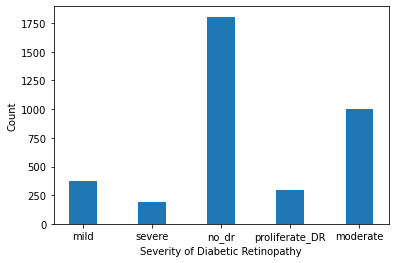

In [5]:
if VERBOSE:
    plt.hist(merged_df.diagnosis, bins=[-0.2, 0.2, 0.8, 1.2, 1.8, 2.2, 2.8, 3.2, 3.8, 4.2])
    plt.xlabel("Severity of Diabetic Retinopathy")
    plt.ylabel("Count")
    plt.show()

In [6]:
def imagePreprocessing(image, normalize=True):
    # Cutting black border.
    row, col = image.shape[0], image.shape[1]
    center_row, center_col = row // 2, col // 2
    x_left, x_right, y_top, y_bot = 0, col, 0, row
    while image[center_row, x_left:x_left + 10].mean().max() <= 10  and x_left < col:
        x_left += 1
    while image[center_row, x_right - 10:x_right].mean().max() <= 10 and x_right > 0:
        x_right -= 1
    while image[y_top:y_top + 10, center_col].mean().max() <= 10 and y_top < row:
        y_top += 1
    while image[y_bot - 10:y_bot, center_col].mean().max() <= 10 and y_bot > 0:
        y_bot -= 1
    if y_top < y_bot and x_left < x_right and y_bot - y_top > 0.6 * row and x_right - x_left > 0.6 * col:
        image = image[y_top:y_bot, x_left:x_right]

    # Cutting to remove black corner.
    row, col = image.shape[0], image.shape[1]
    top_left_x, top_left_y = 0, 0
    while image[0, top_left_x:top_left_x + 10].mean().max() <= 10  and top_left_x < col:
        top_left_x += 1
    while image[top_left_y:top_left_y + 10, 0].mean().max() <= 10  and top_left_y < row:
        top_left_y += 1
    if (top_left_y + top_left_x) != 0 and 2 * np.abs(top_left_y - top_left_x) / (top_left_y + top_left_x) > 0.85:

        crop_left_right = int(0.5 * top_left_x)
        if crop_left_right < 0.3 * col:
            image = image[:, crop_left_right:col - crop_left_right]
    else:
        crop = int(0.15 * (top_left_x + top_left_y) / 2)
        if crop < 0.3 * col and crop < 0.3 * row:
            image = image[crop:row - crop, crop:col - crop]
    
    # Resizing image.
    image = cv2.resize(image, (WIDTH, HEIGHT))
    
    # Applying GaussianBlur.
    blurred = cv2.blur(image, ksize=(int(WIDTH / 6), int(HEIGHT / 6)))
    image = cv2.addWeighted(image, 4, blurred, -4, 128)
    
    try:
        if normalize:
            image = image / 255
            image -= image.mean()
            return image
        else:
            return image
    except:
        return np.zeros((WIDTH, HEIGHT, 3))
	

In [7]:
import cv2
import os
import pandas as pd

# Define your paths and parameters
PATH = "C:\\Users\\Lakshmi\\Untitled Folder 1\\"
PATH_CLASSES = ["mild", "severe", "no_dr", "proliferate_DR", "moderate"]
HEIGHT, WIDTH = 224, 224  # Adjust according to your needs

def openImage(row, resize=False):
    image = None
    class_name = row.diagnosis
    
    # Check if the class folder exists
    if class_name in PATH_CLASSES:
        class_path = os.path.join(PATH, class_name)
        image_path = os.path.join(class_path, f'{row.id_code}.png')
        
        # Check if the image file exists
        if os.path.exists(image_path):
            image = cv2.imread(image_path)
        else:
            print(f"[Error] Could not open the image for row {row.id_code}. Image file not found.")
    else:
        print(f"[Error] Class folder '{class_name}' does not exist.")
    
    if resize and image is not None:
        return cv2.resize(image, (WIDTH, HEIGHT))
    
    return image

# Example usage:
row_example = merged_df.iloc[0]  # Assuming merged_df is the DataFrame with the merged data
image_example = openImage(row_example, resize=True)
print(image_example.shape)  # This will print the shape of the resized image


(224, 224, 3)


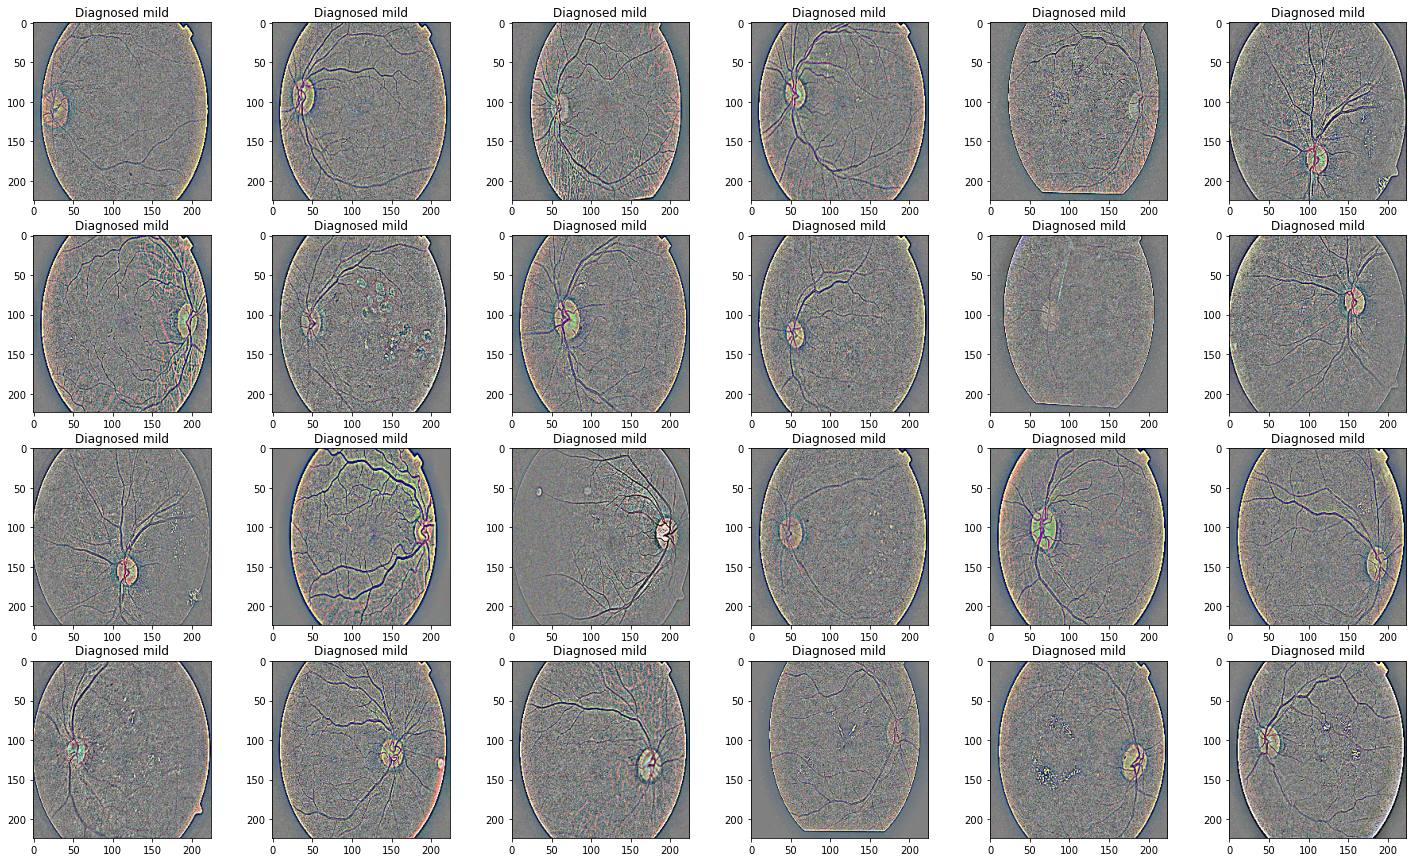

In [8]:
# Assuming imagePreprocessing is defined in a separate cell or script
# Make sure to execute or import the cell/script containing imagePreprocessing

# Define VERBOSE
VERBOSE = True

# Your code for data processing and visualization
if VERBOSE:
    nb_row = 4
    nb_col = 6
    nb = 1
    plt.figure(figsize=(25, 15))
    for row in merged_df.itertuples():
        if nb > nb_col * nb_row:
            break
        plt.subplot(nb_row, nb_col, nb)
        plt.imshow(cv2.cvtColor(imagePreprocessing(openImage(row), normalize=False), cv2.COLOR_BGR2RGB))
        plt.title('Diagnosed {}'.format(row.diagnosis))
        nb += 1
    plt.show()


## RetinaGenerator is the generator for both training and predicting.

In [9]:
class RetinaGenerator():
    def __init__(self, image_df, batch_size, train=True):
        self.image_df = image_df
        self.batch_size = batch_size
        self.train = train
        self.step_per_epoch = len(self.image_df) // self.batch_size
        self.step_per_pred = 1 + (len(self.image_df) - 1) // self.batch_size

    def getGenerator(self):
        while True:
            for idx in range(self.step_per_epoch):
                batch_df = self.image_df[idx * self.batch_size:(idx + 1) * self.batch_size]
                
                # Filter out rows where 'diagnosis' is not a valid integer
                batch_df = batch_df[pd.to_numeric(batch_df['diagnosis'], errors='coerce').notnull()]

                batch_x = np.array([imagePreprocessing(openImage(row)) for row in batch_df.itertuples()])
                batch_y_cat = to_categorical(batch_df['diagnosis'].astype(int), num_classes=5)
                batch_y = np.empty(batch_y_cat.shape, dtype=batch_y_cat.dtype)
                batch_y[:, 4] = batch_y_cat[:, 4]
                for i in range(3, -1, -1):
                    batch_y[:, i] = np.logical_or(batch_y_cat[:, i], batch_y[:, i + 1])
                yield batch_x, batch_y

    def getInputGenerator(self):
        for idx in range(self.step_per_pred + 1):
            batch_df = self.image_df[idx * self.batch_size:min((idx + 1) * self.batch_size, len(self.image_df))]
            
            # Filter out rows where 'diagnosis' is not a valid integer
            batch_df = batch_df[pd.to_numeric(batch_df['diagnosis'], errors='coerce').notnull()]

            yield np.array([imagePreprocessing(openImage(row, self.train)) for row in batch_df.itertuples()])


In [10]:
from IPython.display import display
def create_directory(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory, ignore_errors=True, onerror=None)
    os.mkdir(directory)


# Function to perform data augmentation
def perform_data_augmentation(df, path_augm, augm_factor=1, random_state=None):
    create_directory(path_augm)
    df = shuffle(df, random_state=random_state)
    
    max_size = int(df['diagnosis'].value_counts().max() * augm_factor)

    for diag in range(5):
        create_directory(f'{path_augm}diag_{diag}')
        diag_df = df[df['diagnosis'] == diag]
        size = len(diag_df)
        to_create = max_size - size
        augm_per_img = max(to_create // size, 1) if size > 0 else 1

        for _, row in diag_df.iterrows():
            if to_create <= 0:
                break

            image = cv2.cvtColor(openImage(row, resize=True), cv2.COLOR_BGR2RGB)
            image = np.expand_dims(image, 0)

            data_generator = ImageDataGenerator(rotation_range=360, vertical_flip=True, horizontal_flip=True, zoom_range=0.1)
            data_generator.fit(image)

            id_code = row['id_code_aptos'] if not pd.isnull(row['id_code_aptos']) else row['id_code_2015']

            for x, val in zip(data_generator.flow(image, save_to_dir=f'{path_augm}diag_{diag}', 
                                                  save_prefix=id_code, save_format='png'), 
                              range(augm_per_img - 1)):
                pass

            to_create -= augm_per_img

    for diag in range(5):
        images = np.array(os.listdir(f"{path_augm}diag_{diag}"))
        for image in images:
            df = df.append(pd.DataFrame([[diag, np.nan, np.nan, f"{path_augm}diag_{diag}/{image}"]], columns=df.columns))

    df = shuffle(df, random_state=random_state)
    return df

# Set your variables
DATA_AUGM = True
PATH_AUGM = "C:\\Users\\Lakshmi\\Untitled Folder 1\\gaussian_filtered_images"
RANDOM_STATE = 920

# Check if data augmentation is enabled
if DATA_AUGM:
    df = perform_data_augmentation(merged_df, PATH_AUGM, augm_factor=1, random_state=RANDOM_STATE)
    display(df.head())


id_code diagnosis
1854  b7ce561a7328     no_dr
1628  9bbb6c455913     no_dr
3611  ee2c2a5f7d0e  moderate
1045  4a5a6efc0bef     no_dr
1425  80b5697f2a5e     no_dr

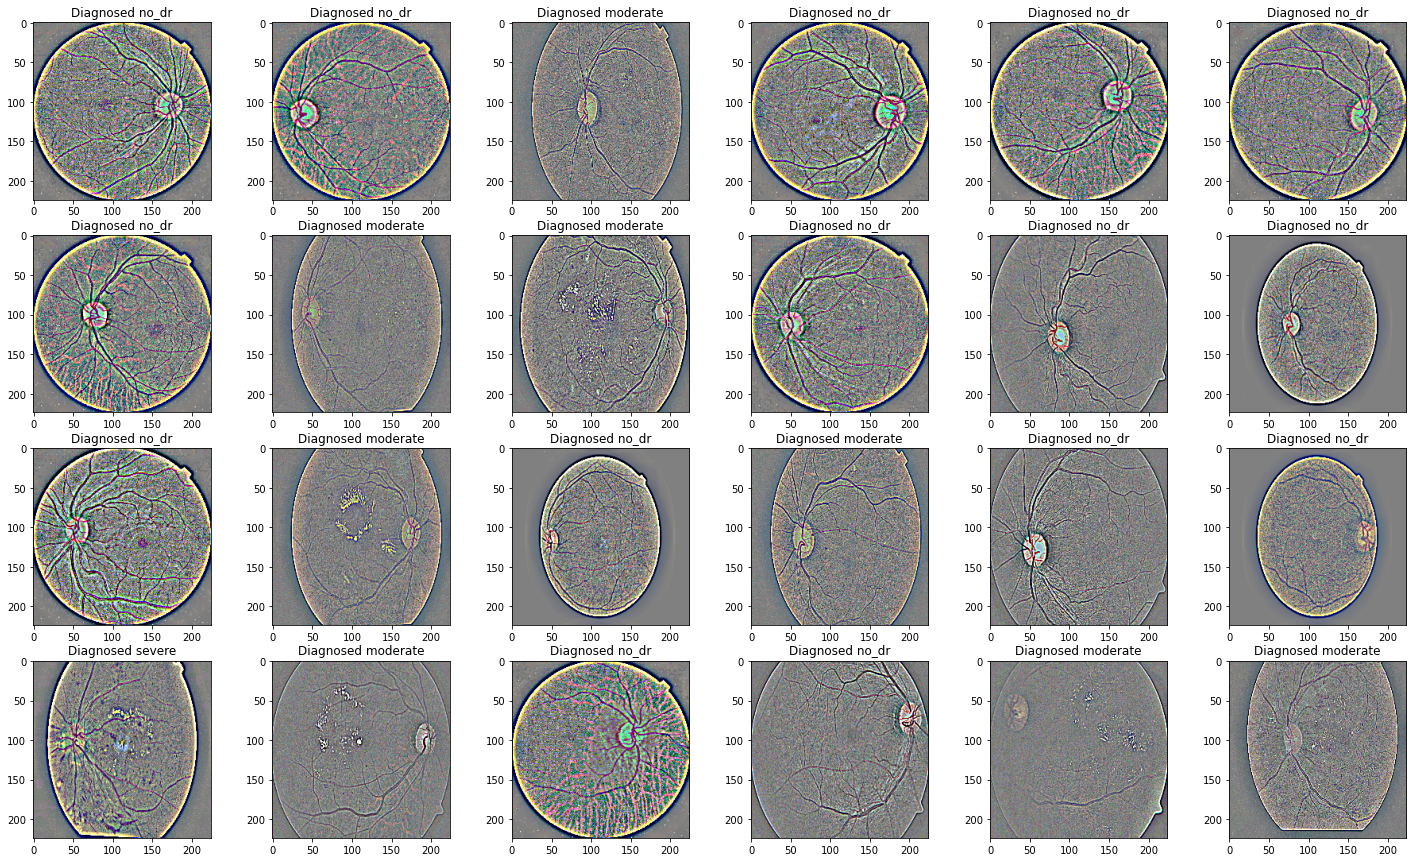

In [11]:
if VERBOSE:
    nb_row = 4
    nb_col = 6
    nb = 1
    plt.figure(figsize=(25, 15))
    for row in df.itertuples():
        if nb > nb_col * nb_row:
            break
        plt.subplot(nb_row, nb_col, nb)
        plt.imshow(cv2.cvtColor(imagePreprocessing(openImage(row), normalize=False), cv2.COLOR_BGR2RGB))
        plt.title('Diagnosed {}'.format(row.diagnosis))
        nb += 1
    plt.show()

 ## Displaying the histogram of our dataset to check if the data augmentation worked.

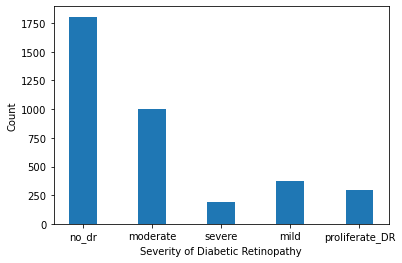

(3662, 2)


In [12]:
if VERBOSE:
    plt.hist(df.diagnosis, bins=[-0.2, 0.2, 0.8, 1.2, 1.8, 2.2, 2.8, 3.2, 3.8, 4.2])
    plt.xlabel("Severity of Diabetic Retinopathy")
    plt.ylabel("Count")
    plt.show()
    print(df.shape)


## Training the model

In [13]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)
train_df, test_df = train_test_split(train_df, test_size=0.005, random_state=RANDOM_STATE)
if VERBOSE:
    print(train_df.shape, val_df.shape, test_df.shape)

(2914, 2) (733, 2) (15, 2)


In [14]:
LEARNING_RATE = 0.005
EPOCHS = 3 # This number is lowered for demonstration purposes, but it's supposed to be way higher
PATIENCE = 16
LR_PATIENCE = 8
VALIDATION_GENERATOR = RetinaGenerator(val_df, 32)
TRAINING_GENERATOR = RetinaGenerator(train_df, 32)
ALL_GENERATOR = RetinaGenerator(df, 32)
STEPS_PER_EPOCH = TRAINING_GENERATOR.step_per_epoch
VALIDATION_STEPS = VALIDATION_GENERATOR.step_per_epoch

## Testing the Model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.add(Dense(5, activation='softmax'))


In [16]:
model

In [18]:
from sklearn.metrics import accuracy_score, cohen_kappa_score

if VERBOSE:
    TEST_GENERATOR = RetinaGenerator(test_df, batch_size=32)  # Replace batch_df with batch_size
    STEPS = TEST_GENERATOR.step_per_pred

    # Create an empty array to store predictions
    Y_pred = []

    # Iterate over batches and make predictions
    for batch in TEST_GENERATOR.getInputGenerator():
        if len(batch) > 0:  # Check if the batch is non-empty
            batch_predictions = model.predict(batch)
            Y_pred.extend((batch_predictions > 0.5).sum(axis=1) - 1)

    # Convert to NumPy array for further calculations
    Y_pred = np.array(Y_pred)

    Y_test = np.array(test_df.diagnosis)

    # Check if Y_pred is not empty before calculating metrics
    if len(Y_pred) > 0:
        print("Average absolute distance is: {:.2f}".format(np.abs(Y_pred - Y_test).mean()))
        display(confusion_matrix(Y_test, Y_pred))
        print("Accuracy Score:" + str(accuracy_score(Y_test, Y_pred)))
        print("Cohen Kappa Score:" + str(cohen_kappa_score(Y_test, Y_pred, weights='quadratic')))
    else:
        print("No predictions made.")


No predictions made.


In [19]:
Y_test.shape


(15,)

In [20]:
if DATA_AUGM:
    shutil.rmtree(PATH_AUGM, ignore_errors=True, onerror=None)

In [29]:
sub_df = pd.read_csv(PATH + 'train.csv')
if VERBOSE:
    print(sub_df.shape)
    display(sub_df.head())


(3662, 2)


id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

In [24]:
sub_df.to_csv('submission.csv', index=False)